This notebook will aim to follow the questions asked in the exploratory data analysis portion of the readme.md file
## import libraries

In [60]:
import gensim
from gensim.models import Word2Vec
from nltk.lm import Vocabulary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from utilities.data_preprocessors import read_preprocess, series_to_1D_array
from utilities.data_visualizers import view_words, view_word_frequency, view_label_freq

import json
import ast

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## loading data
recall that the the comments have designated labels which are 2, 1, and 0 representing derogatory, non-derogatory, and offensive comments respectively

In [61]:
df = pd.read_csv('./data/hate-speech-data-cleaned.csv', index_col=0)
df = read_preprocess(df)
df

,comment,label
0,"[woman, complain, cleaning, house, man, always...",1
1,"[boy, dat, coldtyga, dwn, bad, cuffin, dat, ho...",0
2,"[dawg, ever, fuck, bitch, start, cry, confused...",0
3,"[look, like, tranny]",0
4,"[shit, hear, might, true, might, faker, bitch,...",0
...,...,...
65775,"[from, the, midnight, sun, where, the, hot, sp...",1
65776,"[do, not, say, am, not, your, type]",1
65777,"[and, therefor, never, send, to, know, for, wh...",1
65778,"[and, cannot, stand, anoth, day]",1


# Details about the dataframe
in summary classes are now to be the ff:
- NON-DEROGATORY 1
- OFFENSIVE 0
- DEROGATORY 2
- HOMONYM 3

In [62]:
label_freq = df['label'].value_counts()
label_freq



2    22395
1    21644
0    19743
3     1998
Name: label, dtype: int64

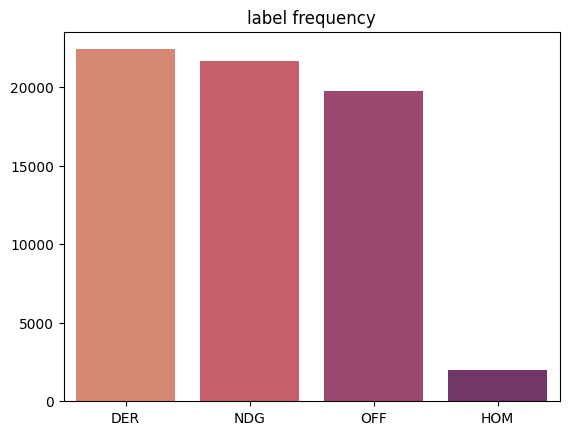

In [63]:
view_label_freq(label_freq, 'label frequency')

In [64]:
# extract diagnosis as Y then
# transform Y to 2-dim 1 x m matrix
Y = df['label']
Y = Y.to_numpy().reshape(Y.shape[0], -1)

# extract comment column
X = df['comment']

In [65]:
type(X.iloc[0])

list

In [66]:
X.iloc[0]
# X[0]

['woman', 'complain', 'cleaning', 'house', 'man', 'always', 'take', 'trash']

## Exploratory data analysis before generating embeddings

determine count of each unique word

maybe isolate thhose that are 

In [67]:
all_words = pd.Series(series_to_1D_array(X))
all_unique_words_counts = all_words.value_counts()
all_unique_words = all_words.unique()


In [68]:
all_words.shape

(894878,)

In [69]:
len(all_unique_words)

47921

In [70]:
all_unique_words_counts

nigger         16186
faggot         14812
bitch          12246
tranny         11850
like           11657
               ...  
pty                1
vocorp             1
sometimesin        1
shon               1
maupin             1
Length: 47921, dtype: int64

In [71]:
derog_idxs = (Y == 2).reshape(-1)
non_derog_idxs = (Y == 1).reshape(-1)
off_idxs = (Y == 0).reshape(-1)
hom_idxs = (Y == 3).reshape(-1)

# vocabulary of derogatory comments
flat_derog = series_to_1D_array(X[derog_idxs])
derog_vocab = pd.Series(flat_derog)
derog_counts = derog_vocab.value_counts()
derog_words = derog_vocab.unique()

In [72]:
len(flat_derog)

311480

In [73]:
derog_counts

faggot        8625
nigger        6821
tranny        6414
like          4049
would         2392
              ... 
groaning         1
iosandroid       1
fewer            1
juke             1
hamud            1
Length: 26365, dtype: int64

In [74]:
# vocabulary of non-derogatory comments
flat_non_derog = series_to_1D_array(X[non_derog_idxs])
non_derog_vocab = pd.Series(flat_non_derog)
non_derog_counts = non_derog_vocab.value_counts()
non_derog_words = non_derog_vocab.unique()

In [75]:
len(flat_non_derog)

385058

In [76]:
non_derog_counts

nigger     9181
people     6027
faggot     5568
word       4816
like       4674
           ... 
doar          1
ia            1
vrei          1
pstrezi       1
toll          1
Length: 27267, dtype: int64

In [77]:
# vocabulary of offensive comments
flat_off = series_to_1D_array(X[off_idxs])
off_vocab = pd.Series(flat_off)
off_counts = off_vocab.value_counts()
off_words = off_vocab.unique()

In [78]:
len(flat_off)

149068

In [79]:
off_counts

bitch       11064
hoe          4138
like         2469
pussy        2161
nigga        1778
            ...  
gorg            1
june            1
marathon        1
nvr             1
chatting        1
Length: 15865, dtype: int64

In [80]:
# vocabulary of homonymoys comments
flat_hom = series_to_1D_array(X[hom_idxs])
hom_vocab = pd.Series(flat_hom)
hom_counts = hom_vocab.value_counts()
hom_words = hom_vocab.unique()

In [81]:
len(flat_hom)

49272

In [82]:
hom_counts

tranny     2032
car         710
like        465
would       420
k           372
           ... 
lux           1
kidney        1
grill         1
fog           1
initial       1
Length: 7087, dtype: int64

**each class' word count not applying the constrain of having words be unique or non-duplicated**
* for derogatory comments there are about 311480 words all in all. And this is not putting it in the constraint of being unique
* for non-derogatory comments there are about 385058 words all in all. Not again applying the constraint of the words being unique
* for offensive comments there are about 149068 words all in all. Not again applying the constraint of the words being unique. Meaning some words maybe repeated or more
* for homonymous comments there are about 49272 words all in all. Not again applying the constraint of the words being unique

**each class' unique word count**
* for derogatory comments there are about 26365 unique words
* for non-derogatory comments there are about 27267 unique words
* for offensive comments there are about 15865 unique words
* for homonymous comments there are about 7087 unique words

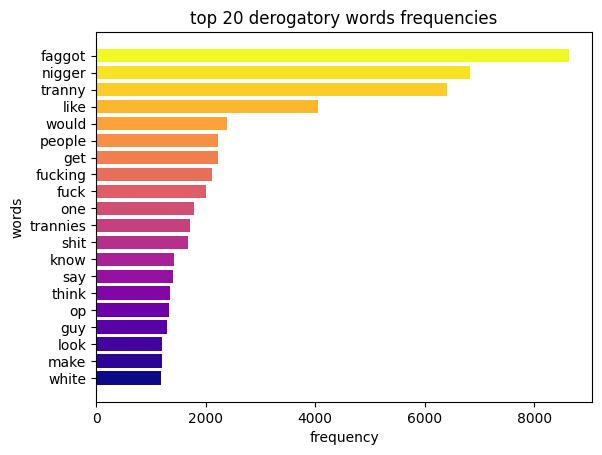

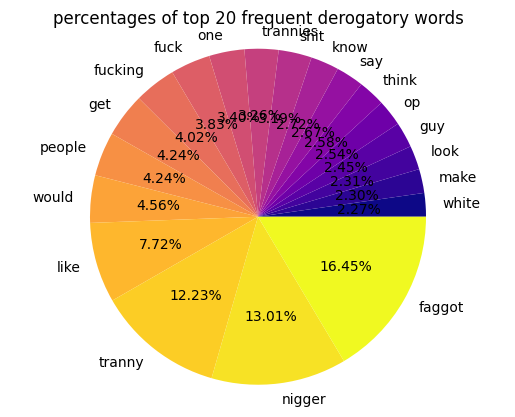

In [83]:
view_word_frequency(derog_counts, colormap='plasma', title='top 20 derogatory words frequencies', limit=20)
view_word_frequency(derog_counts, colormap='plasma', title='percentages of top 20 frequent derogatory words', kind='pie', limit=20)

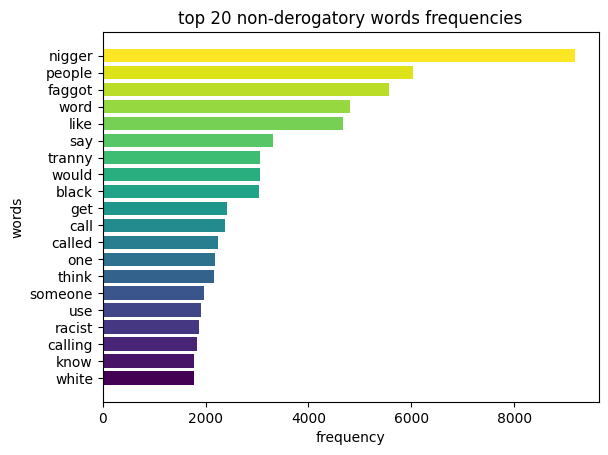

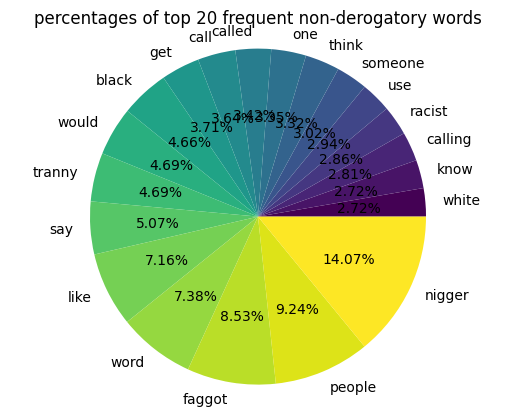

In [84]:
view_word_frequency(non_derog_counts, colormap='viridis', title='top 20 non-derogatory words frequencies', limit=20)
view_word_frequency(non_derog_counts, colormap='viridis', title='percentages of top 20 frequent non-derogatory words', kind='pie', limit=20)

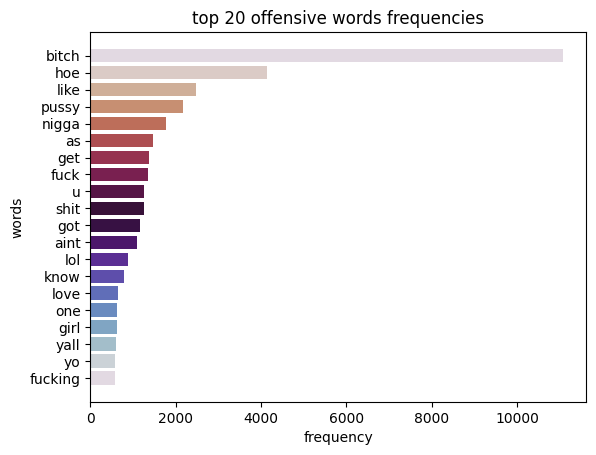

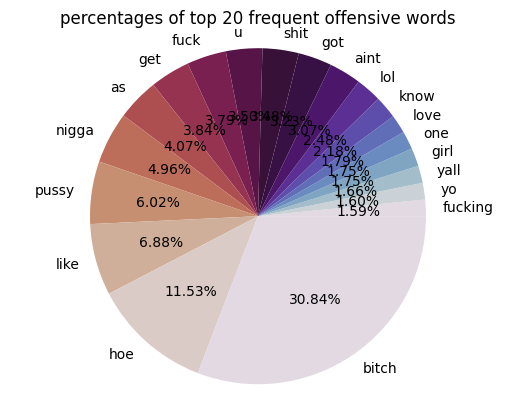

In [85]:
view_word_frequency(off_counts, colormap='twilight', title='top 20 offensive words frequencies', limit=20)
view_word_frequency(off_counts, colormap='twilight', title='percentages of top 20 frequent offensive words', kind='pie', limit=20)

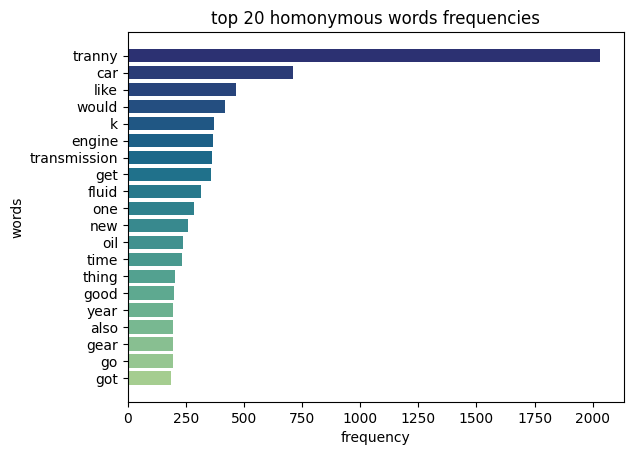

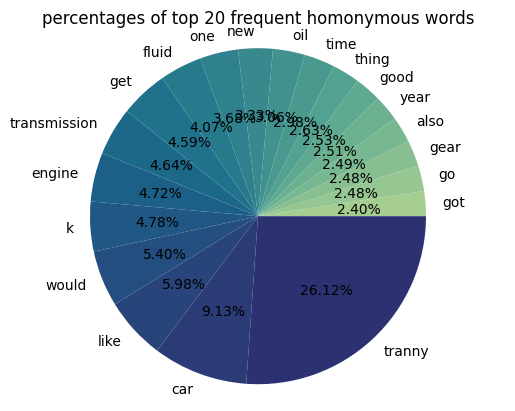

In [86]:
view_word_frequency(hom_counts, colormap='crest', title='top 20 homonymous words frequencies', limit=20)
view_word_frequency(hom_counts, colormap='crest', title='percentages of top 20 frequent homonymous words', kind='pie', limit=20)